In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np 
import pandas as pd 

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

In [2]:
df = pd.read_csv("diabetes_prediction.csv")

In [5]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.00,0,0,No Info,27.32,6.20,90,0
99996,Female,2.00,0,0,No Info,17.37,6.50,100,0
99997,Male,66.00,0,0,former,27.83,5.70,155,0
99998,Female,24.00,0,0,never,35.42,4.00,100,0


In [6]:
# Handle duplicates
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [7]:
df = df.drop_duplicates()

In [8]:
# Loop through each column and count the number of distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [9]:
# Checking null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [10]:
# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

In [11]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


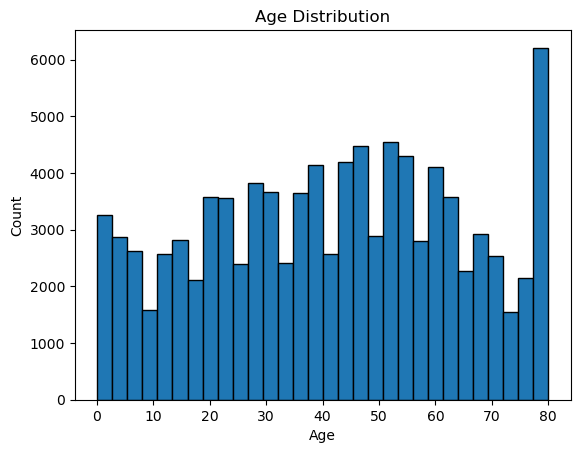

In [12]:
# Histogram for age
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

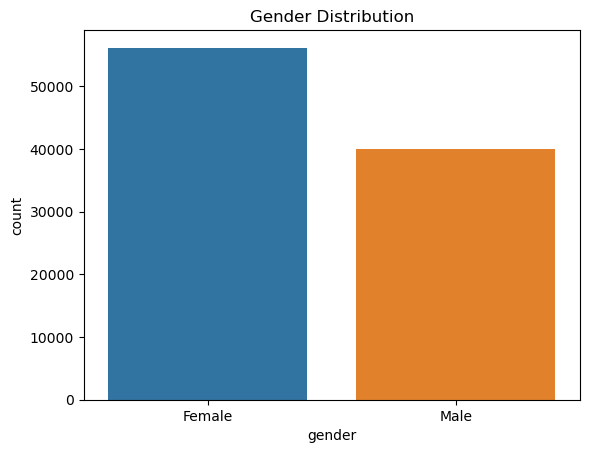

In [13]:
# Bar plot for gender
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

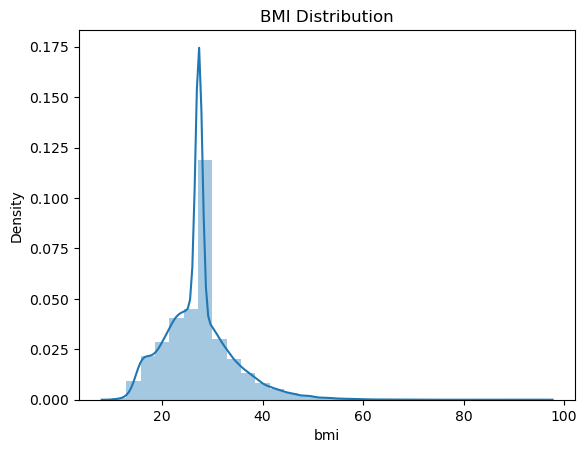

In [14]:
# Distribution plot for BMI
sns.distplot(df['bmi'], bins=30)
plt.title('BMI Distribution')
plt.show()

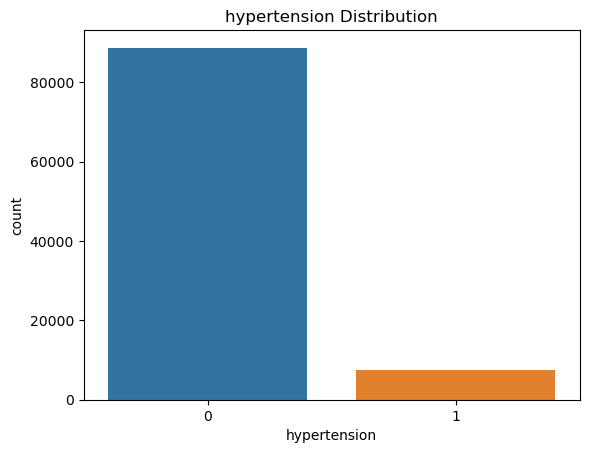

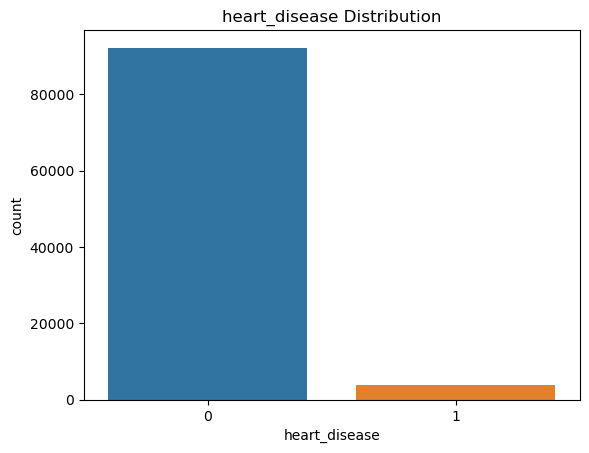

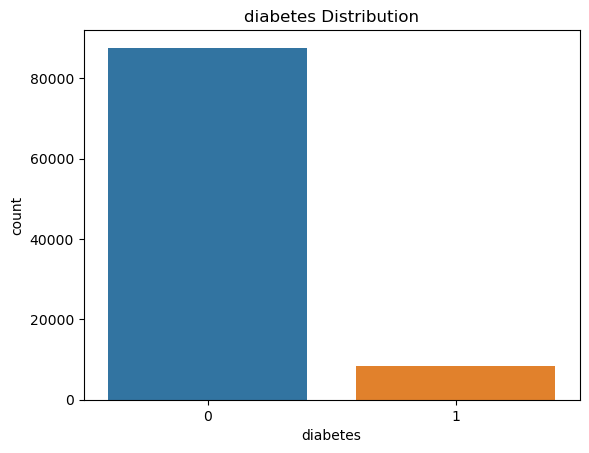

In [15]:
# Count plots for binary variables
for col in ['hypertension', 'heart_disease', 'diabetes']:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Distribution')
    plt.show()

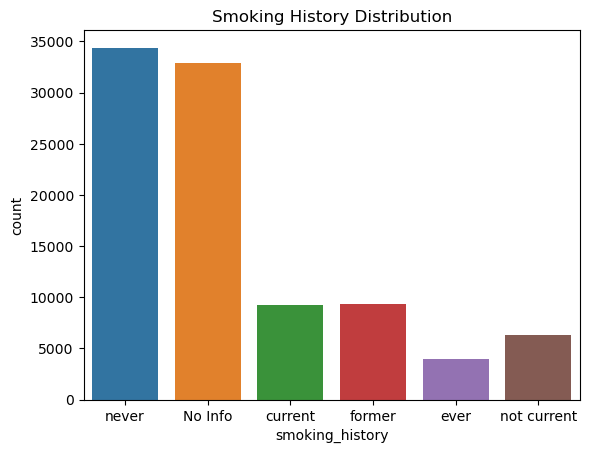

In [16]:
# Count plot for smoking history
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')
plt.show()

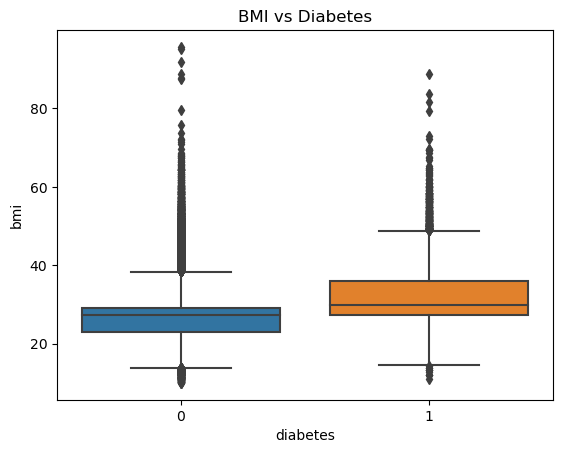

In [17]:
# Boxplot BMI vs Diabetes classification
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diabetes')
plt.show()

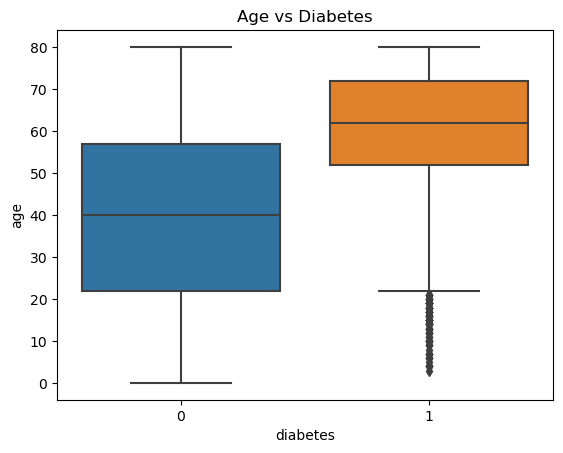

In [18]:
# Boxplot Age vs Diabetes classification
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()

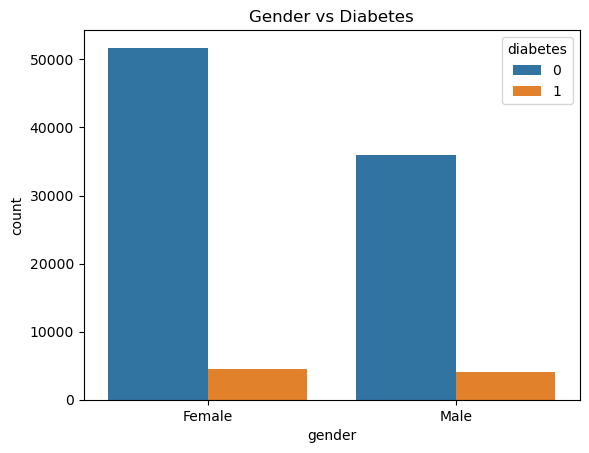

In [19]:
# Count plot of gender vs diabetes
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title('Gender vs Diabetes')
plt.show()

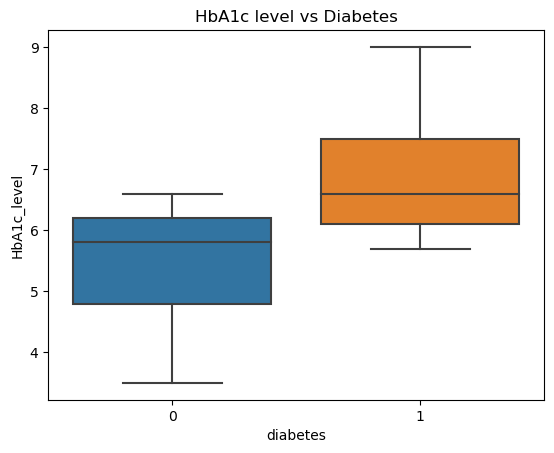

In [20]:
# Boxplot HbA1c level vs Diabetes classification
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c level vs Diabetes')
plt.show()

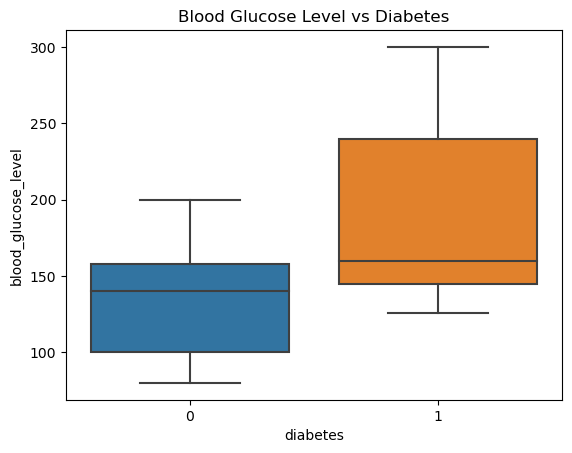

In [21]:
# Boxplot blood glucose level vs Diabetes classification
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()

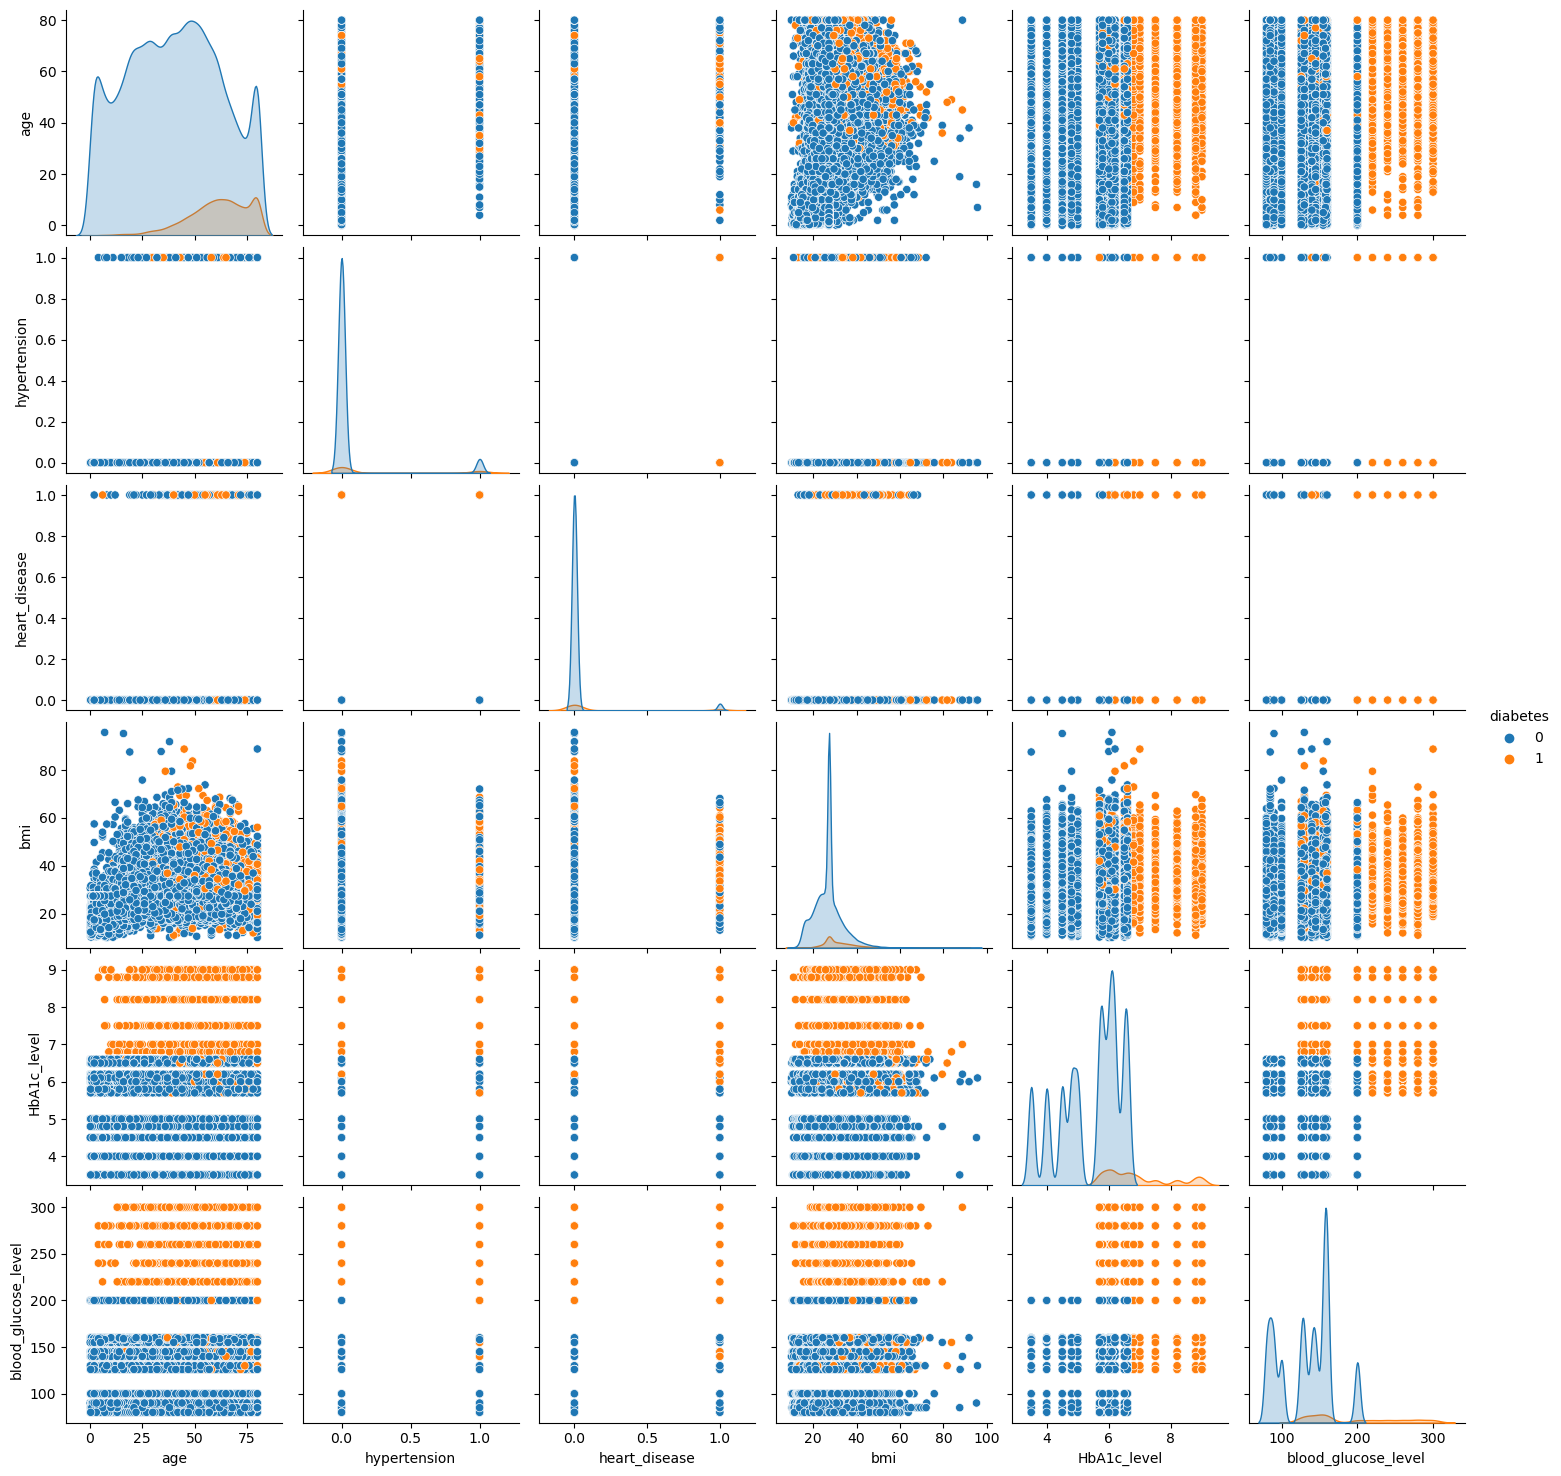

In [22]:
# Pair plot for numeric features
sns.pairplot(df, hue='diabetes')
plt.show()

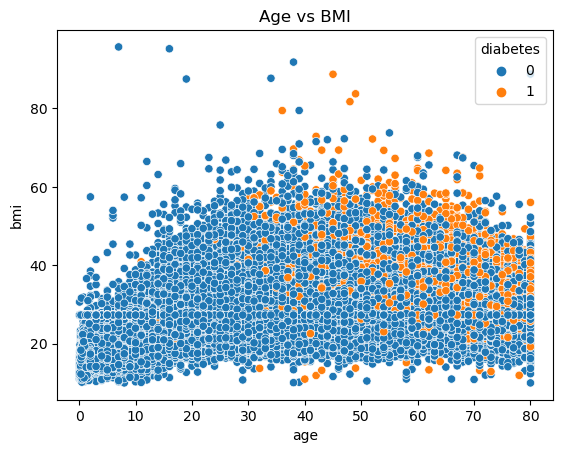

In [23]:
# Scatterplot Age vs BMI colored by Diabetes classification
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df)
plt.title('Age vs BMI')
plt.show()

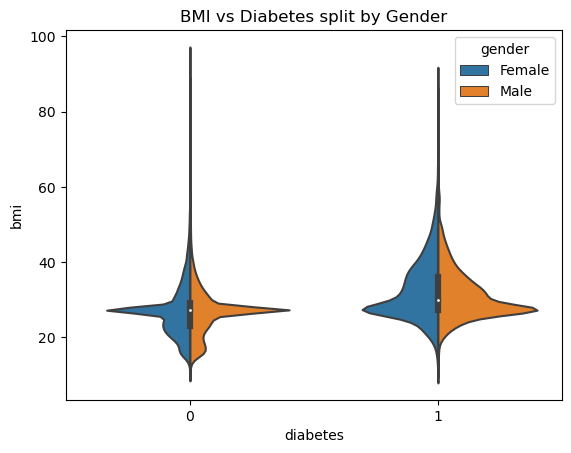

In [24]:
# Violin plot of BMI against diabetes classification split by gender
sns.violinplot(x='diabetes', y='bmi', hue='gender', split=True, data=df)
plt.title('BMI vs Diabetes split by Gender')
plt.show()

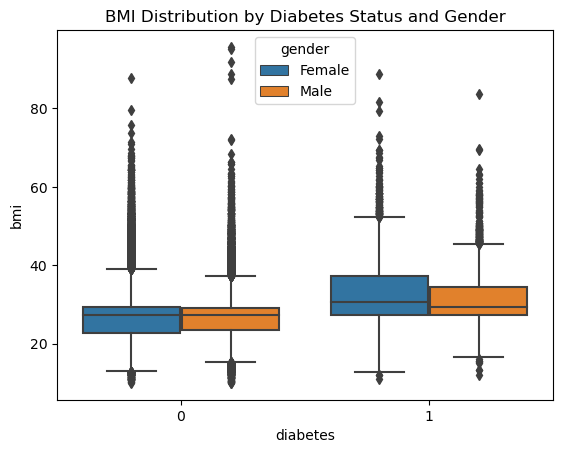

In [25]:
# Interaction between gender, BMI and diabetes
sns.boxplot(x='diabetes', y='bmi', hue='gender', data=df)
plt.title('BMI Distribution by Diabetes Status and Gender')
plt.show()

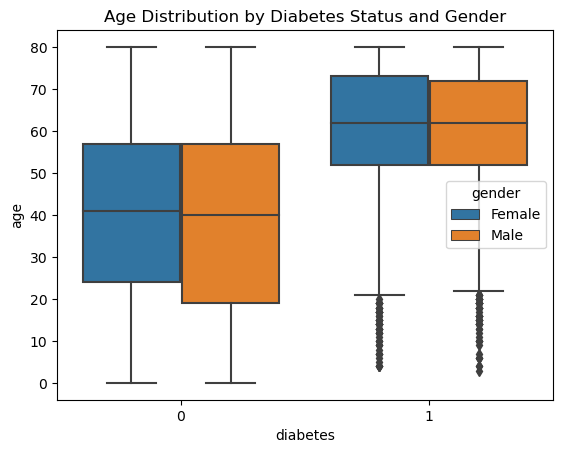

In [26]:
# Interaction between gender, Age and diabetes
sns.boxplot(x='diabetes', y='age', hue='gender', data=df)
plt.title('Age Distribution by Diabetes Status and Gender')
plt.show()

In [27]:
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

non-smoker     67276
past_smoker    19655
current         9197
Name: smoking_history, dtype: int64


In [28]:
data = df.copy()

In [29]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

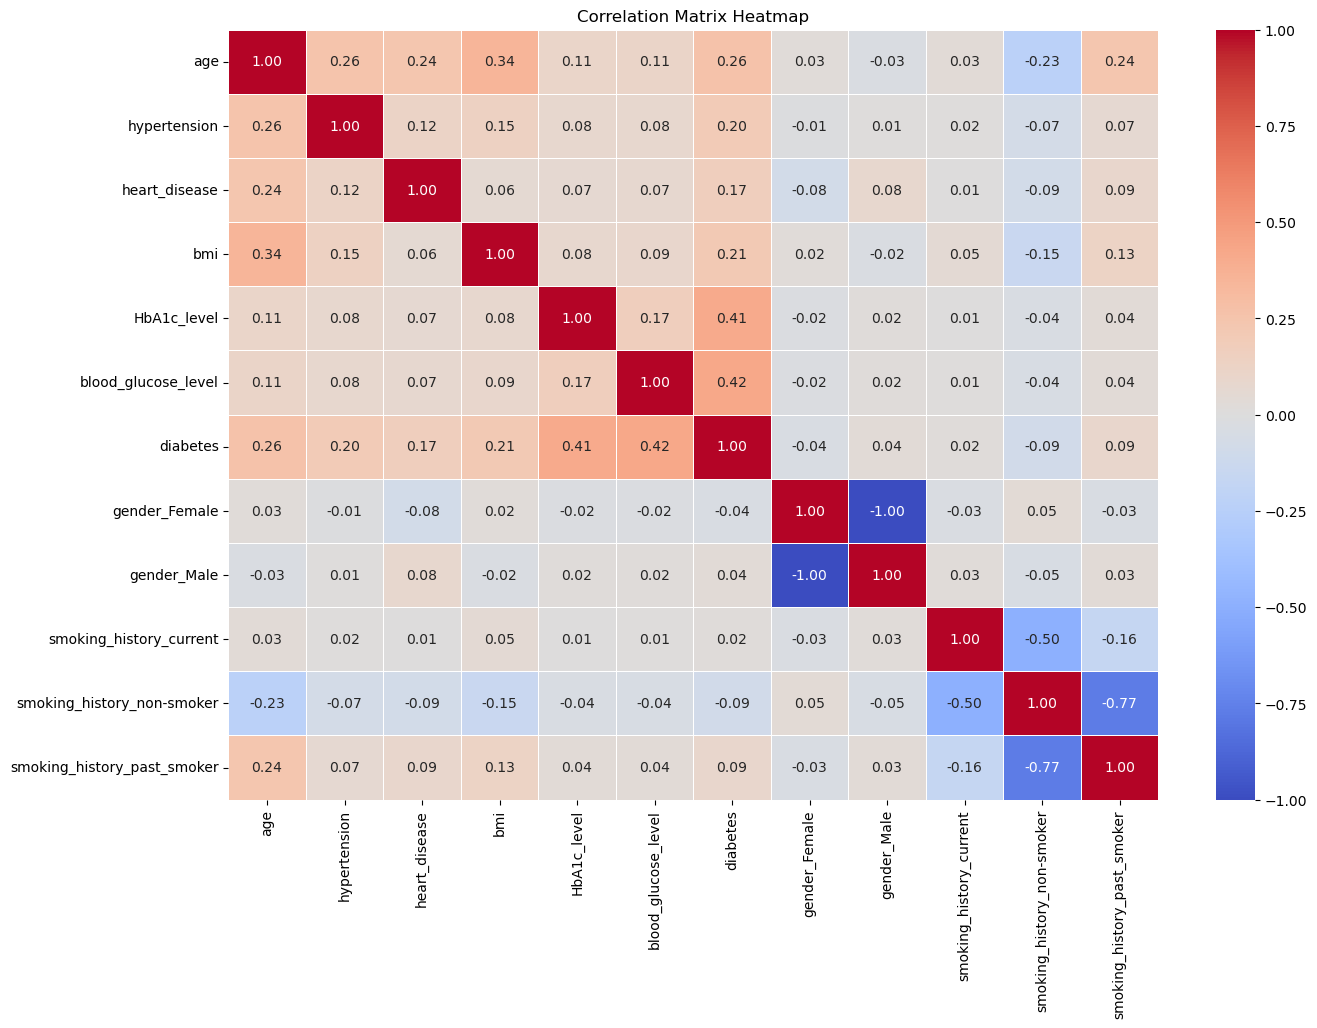

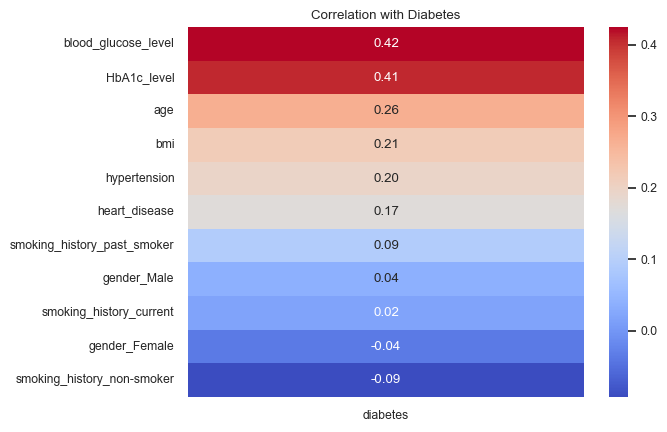

In [30]:
# Compute the correlation matrix
correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

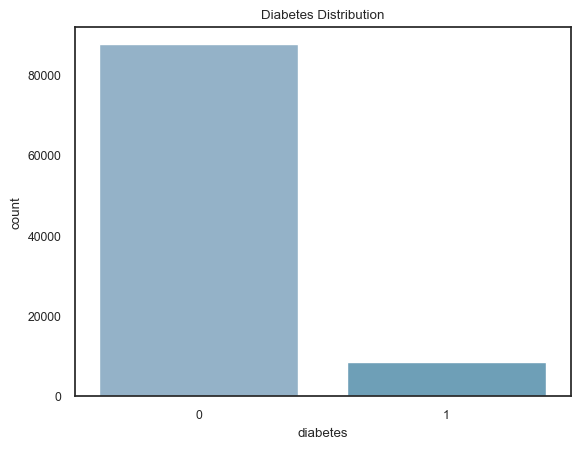

In [31]:
# Count plot for the 'diabetes' variable
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [32]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [33]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [34]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [35]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [36]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}


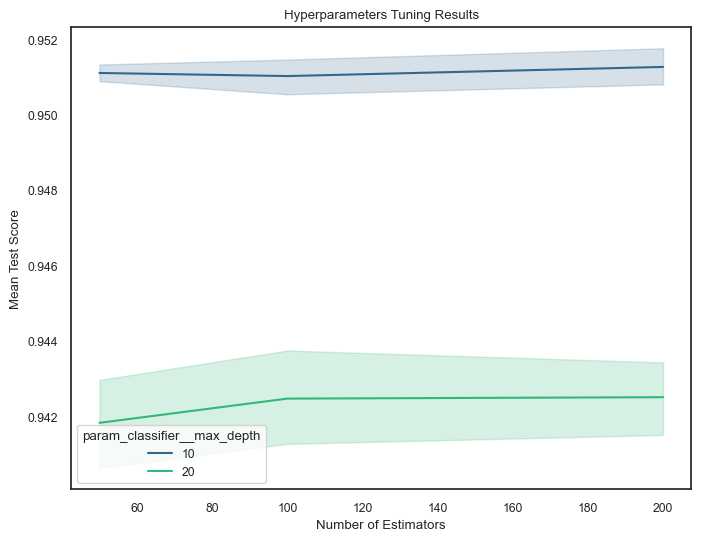

In [37]:
# Convert GridSearchCV results to a DataFrame and plot
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

Model Accuracy:  0.9502756683657547
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17525
           1       0.69      0.79      0.74      1701

    accuracy                           0.95     19226
   macro avg       0.84      0.88      0.86     19226
weighted avg       0.95      0.95      0.95     19226



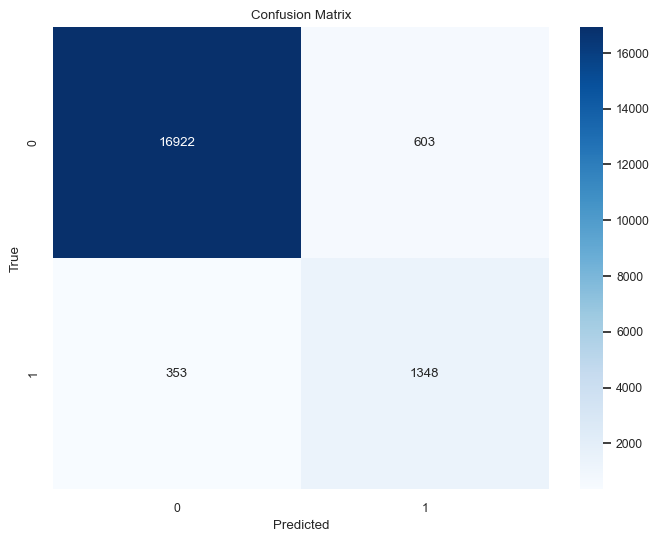

In [38]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

                        Feature  Importance
2                   HbA1c_level        0.45
3           blood_glucose_level        0.31
0                           age        0.12
1                           BMI        0.07
4                  hypertension        0.03
5                 heart_disease        0.02
9    smoking_history_non-smoker        0.00
10  smoking_history_past_smoker        0.00
6                 gender_Female        0.00
7                   gender_Male        0.00
8       smoking_history_current        0.00


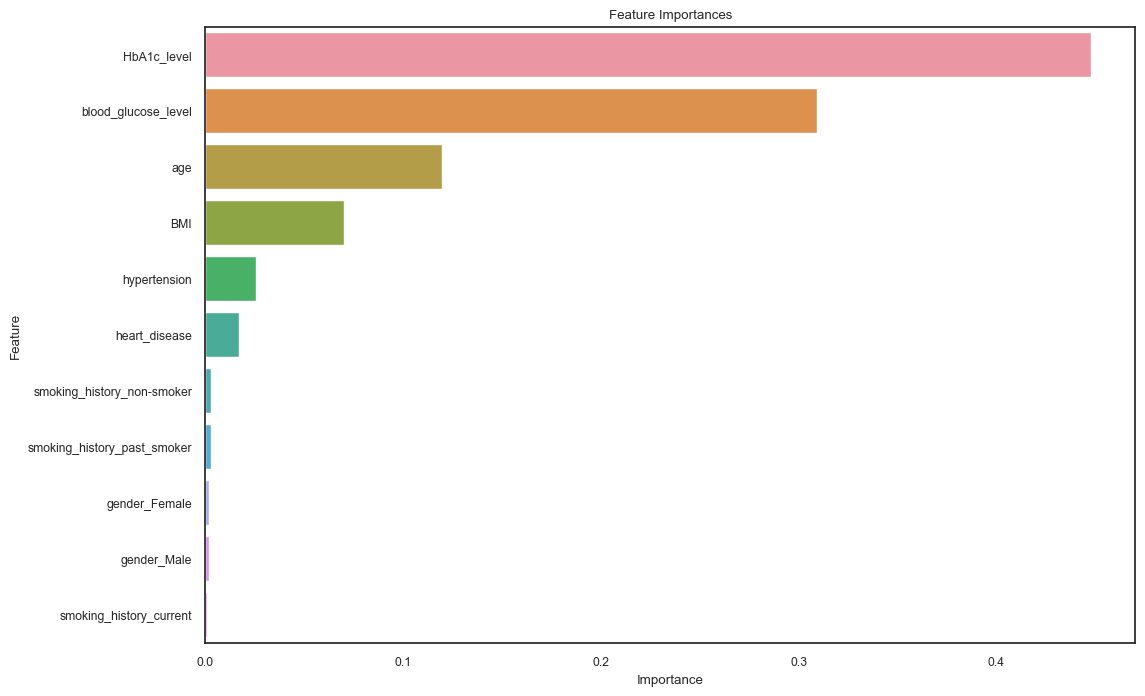

In [39]:
# After fitting the model, we input feature names
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))

# Then we add the numeric feature names
feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

# And now let's get the feature importances
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()